In [1]:
import carla
import math
import random
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

import queue

from simple_carla_env import CarlaEnv

In [37]:
def loc2array(loc: carla.Location) -> np.ndarray:
    return np.array([loc.x, loc.y, loc.z])


In [7]:
np.tanh(np.arange(0, 1, 0.01))

array([0.        , 0.00999967, 0.01999733, 0.029991  , 0.03997868,
       0.04995837, 0.0599281 , 0.06988589, 0.07982977, 0.08975778,
       0.09966799, 0.10955847, 0.1194273 , 0.12927258, 0.13909245,
       0.14888503, 0.1586485 , 0.16838105, 0.17808087, 0.18774621,
       0.19737532, 0.2069665 , 0.21651806, 0.22602835, 0.23549575,
       0.24491866, 0.25429553, 0.26362484, 0.27290508, 0.28213481,
       0.29131261, 0.3004371 , 0.30950692, 0.31852078, 0.32747739,
       0.33637554, 0.34521403, 0.35399171, 0.36270747, 0.37136023,
       0.37994896, 0.38847268, 0.39693043, 0.40532131, 0.41364444,
       0.42189901, 0.43008421, 0.43819931, 0.44624361, 0.45421643,
       0.46211716, 0.4699452 , 0.47770001, 0.48538109, 0.49298797,
       0.50052021, 0.50797743, 0.51535928, 0.52266543, 0.52989561,
       0.53704957, 0.5441271 , 0.55112803, 0.55805222, 0.56489955,
       0.57166997, 0.57836341, 0.58497988, 0.5915194 , 0.597982  ,
       0.60436778, 0.61067683, 0.6169093 , 0.62306535, 0.62914

In [38]:
env = CarlaEnv(n_exo_vehicles=30)
obs, info = env.reset()

KeyboardInterrupt: 

In [ ]:
for i in range(20):
    obs, reward, term, trunc, info = env.step([1.0, 0.0])
    env._set_spectator()

    # print(info["heading_angle"], info["heading_angle2"])
    print(info["dist_to_lane_center"])

    # print([(v.get_velocity().x, v.get_velocity().y) for v in env.vehicle_list])

    # # print(obs["observation"].shape)
    # plt.imshow(obs["observation"])
    # plt.show()


(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
0.0
(888,)
2.86102294921875e-06
(864,)
2.86102294921875e-06
(864,)
2.86102294921875e-06
(864,)
-1.239776611328125e-05
(864,)
-0.00012683868408203125
(864,)
-0.000102996826171875
(864,)
-0.000148773193359375


In [ ]:
# plt.imshow(obs["observation"])

In [ ]:
ego_location = env.ego_vehicle.get_location()
ego_speed = np.linalg.norm(loc2array(env.ego_vehicle.get_velocity())[:2])  # in m/s
ego_accel = np.linalg.norm(loc2array(env.ego_vehicle.get_acceleration())[:2])
ego_waypoint = env.map.get_waypoint(ego_location, project_to_road=True)
ego_waypoint_loc = ego_waypoint.transform.location
dist_to_lane_center = loc2array(ego_location) - loc2array(ego_waypoint_loc)

reward = 0
term = False
trunc = False

info = {
    "ego_location": loc2array(ego_location),
    "ego_waypoint": loc2array(ego_waypoint_loc),
    "ego_speed": ego_speed,
    "ego_accel": ego_accel,
    "dist_to_lane_center": dist_to_lane_center,
    "lane_id": ego_waypoint.lane_id,
    "road_id": ego_waypoint.road_id,
    # "collision": sensor_data["collision"],
    # "lane_invasion": sensor_data["lane_invasion"],
}

info

{'ego_location': array([8.74565315e+00, 6.55038681e+01, 2.19260585e-02]),
 'ego_waypoint': array([ 8.74580193, 65.5038681 ,  0.        ]),
 'ego_speed': 2.781209790330904,
 'ego_accel': 5.114580984035992,
 'dist_to_lane_center': array([-0.00014877,  0.        ,  0.02192606]),
 'lane_id': -2,
 'road_id': 47}

In [ ]:
v_vec = env.ego_vehicle.get_transform().get_forward_vector()
w_vec = ego_waypoint.transform.get_forward_vector()
v_vec.get_vector_angle(w_vec)

0.004657910671085119

In [ ]:
def get_rel_angle(target_transform, reference_transform):
    _vec = reference_transform.get_forward_vector()
    ref_vec = np.array([_vec.x, _vec.y])
    target_vec = np.array([
        target_transform.location.x - reference_transform.location.x,
        target_transform.location.y - reference_transform.location.y
    ])
    norm_target = np.linalg.norm(target_vec)
    angle = math.degrees(np.arccos(np.clip(np.dot(ref_vec, target_vec) / norm_target, -1., 1.)))

    return angle

In [ ]:
vc = []

distances = []

print(len(env.vehicle_list))


ego_transform = env.ego_vehicle.get_transform()
ego_location = ego_transform.location
ego_vec = ego_transform.get_forward_vector()
ego_wpt = env.map.get_waypoint(ego_location)

print("ego location:", ego_location)
print("ego vec:", ego_vec)

for v in env.vehicle_list:
    target_transform = v.get_transform()
    if target_transform == ego_transform:
        continue
    
    else:
        target_wpt = env.map.get_waypoint(target_transform.location, lane_type=carla.LaneType.Any)
       
        # if target_wpt.lane_id == ego_wpt.lane_id:
        if True:
            target_location = target_transform.location
            target_vec = target_transform.get_forward_vector()
            dist = np.linalg.norm(loc2array(target_location)-loc2array(ego_location))
            rel_angle = get_rel_angle(ego_transform, target_transform)  
            if dist < 50 and rel_angle > 90:
                print(v.type_id)
                print(loc2array(v.get_transform().location))
                print("dist:", dist)
                print("target location:", target_location)
                print("target vec: ",  target_vec)
                print("ego-target vec: ", ego_vec - target_vec)
                print("vec angle: ", ego_vec.get_vector_angle(target_vec))


            # print(get_rel_angle(target_transform, ego_transform))

print(len(vc))

29
ego location: Location(x=8.745653, y=65.503868, z=0.021926)
ego vec: Vector3D(x=-0.004787, y=-0.999978, z=-0.004663)
vehicle.dodge.charger_police_2020
[5.05305243e+00 2.73165627e+01 1.10609108e-06]
dist: 38.365428166493075
target location: Location(x=5.053052, y=27.316563, z=0.000001)
target vec:  Vector3D(x=-0.005046, y=-0.999987, z=0.000000)
ego-target vec:  Vector3D(x=0.000259, y=0.000010, z=-0.004663)
vec angle:  0.004657910671085119
vehicle.citroen.c3
[15.02183151 27.14393997 10.99962234]
dist: 40.39039881938191
target location: Location(x=15.021832, y=27.143940, z=10.999622)
target vec:  Vector3D(x=0.999992, y=0.004061, z=0.000000)
ego-target vec:  Vector3D(x=-1.004779, y=-1.004038, z=-0.004663)
vec angle:  1.5796438455581665
0


In [ ]:
def add_exo():
    blueprint = random.choice(env.exo_bps)
    blueprint.set_attribute("role_name", "hero")  # or ego
    transform = env.ego_vehicle.get_transform()
    transform.location.y -= 5
    transform.location.x -= 5
    # ego_location = env.ego_vehicle.get_location()
    # transform = env.map.get_waypoint(ego_location, project_to_road=True).get_right_lane().transform
    
    vehicle = env.world.spawn_actor(blueprint=blueprint, transform=transform)
    return vehicle

ev = add_exo()
env.world.tick()

13585

In [ ]:
env._set_spectator()
env.world.tick()

13586

In [ ]:
transform = carla.Transform(
    env.ego_vehicle.get_transform().transform(carla.Location(x=0, z=2.5)),
    env.ego_vehicle.get_transform().rotation,
)
env._set_spectator(transform)
env.world.tick()

13587

In [ ]:
transform = carla.Transform(
    ev.get_transform().transform(carla.Location(x=-20, z=2.5)),
    ev.get_transform().rotation,
)
env._set_spectator(transform)
env.world.tick()

13588

In [ ]:
env._set_spectator()
env.world.tick()

13589

In [ ]:
env.world.tick()

13590

In [ ]:
loc2array(target_transform.location)

array([8.74565315e+00, 6.55038681e+01, 2.19260585e-02])

In [ ]:

print(loc2array(ev.get_transform().location))
print(loc2array(ego_waypoint.transform.location))

[3.74564075e+00 6.05018425e+01 5.16454456e-03]
[ 8.74580193 65.5038681   0.        ]


In [ ]:
loc2array(ego_waypoint.transform.location)

array([ 8.74580193, 65.5038681 ,  0.        ])

In [ ]:
w = ego_waypoint
wps = []
for i in range(1000):
    w = w.next(0.1)[0]
    wps.append(w)

In [ ]:
ds = []
for w in wps:
    d = np.linalg.norm(loc2array(w.transform.location) - loc2array(ev.get_transform().location))
    ds.append(d)
   

In [ ]:
np.argmin(ds) * 0.1

4.9

In [ ]:

np.linalg.norm(loc2array(ev.get_transform().location) - loc2array(ego_waypoint.transform.location))

7.072616103935261

In [ ]:
"""

filter vehicles that are
    - too far away
    - behind ego

for i, wp in ego_vehilce.next_waypoints
    
    for v in other vehicles
        if dist(wp, other) < extent + margin:
            return i 
"""

'\n\nfilter vehicles that are\n    - too far away\n    - behind ego\n\nfor i, wp in ego_vehilce.next_waypoints\n    \n    for v in other vehicles\n        if dist(wp, other) < extent + margin:\n            return i \n'

In [ ]:
all_wps = env.map.generate_waypoints(30.0)
a_locs = np.array([(w.transform.location.x, w.transform.location.y) for w in all_wps])

w = ego_waypoint
ego_wps = []
for i in range(100):
    w = w.next(1)[0]
    ego_wps.append(w)

e_locs = np.array([(w.transform.location.x, w.transform.location.y) for w in ego_wps])

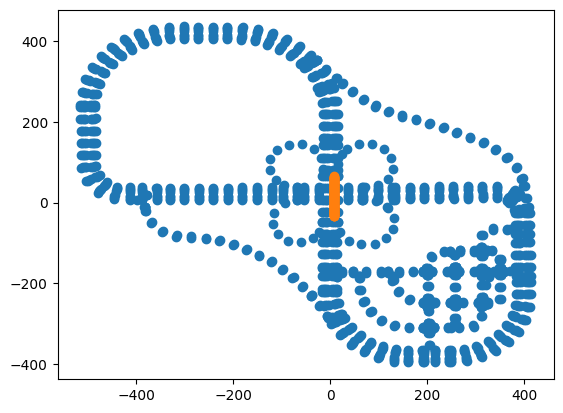

In [ ]:

plt.scatter(a_locs[:, 0], a_locs[:, 1])
plt.scatter(e_locs[:, 0], e_locs[:, 1])

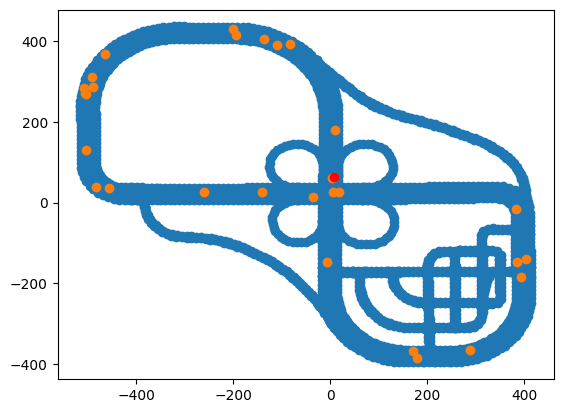

In [ ]:
def vis_map(env):
    road_wps = env.map.generate_waypoints(10.0)
    road_locs = np.array([loc2array(w.transform.location) for w in road_wps])

    vehicle_locs = np.stack([loc2array(v.get_location()) for v in env.vehicle_list])
    ego_loc = loc2array(env.ego_vehicle.get_location())
        


    plt.scatter(road_locs[:, 0], road_locs[:, 1])
    plt.scatter(vehicle_locs[:, 0], vehicle_locs[:, 1])
    plt.scatter(ego_loc[0], ego_loc[1], color="red")

vis_map(env)

In [ ]:
dir(ego_waypoint)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'get_junction',
 'get_landmarks',
 'get_landmarks_of_type',
 'get_left_lane',
 'get_right_lane',
 'id',
 'is_intersection',
 'is_junction',
 'junction_id',
 'lane_change',
 'lane_id',
 'lane_type',
 'lane_width',
 'left_lane_marking',
 'next',
 'next_until_lane_end',
 'previous',
 'previous_until_lane_start',
 'right_lane_marking',
 'road_id',
 's',
 'section_id',
 'transform']

In [ ]:
ego_waypoint.get_left_lane().transform.location.x, ego_waypoint.get_left_lane().transform.location.y

(5.245846748352051, 65.52153015136719)

In [ ]:
ego_waypoint.get_right_lane().transform.location.x, ego_waypoint.get_right_lane().transform.location.y

(12.245758056640625, 65.4862060546875)

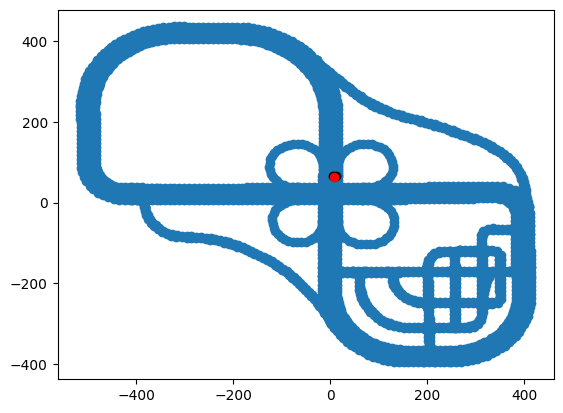

In [ ]:
def vis_map(env):
    road_wps = env.map.generate_waypoints(10.0)
    road_locs = np.array([loc2array(w.transform.location) for w in road_wps])

    vehicle_locs = np.stack([
        (ego_waypoint.get_left_lane().transform.location.x, ego_waypoint.get_left_lane().transform.location.y),
        (ego_waypoint.get_right_lane().transform.location.x, ego_waypoint.get_right_lane().transform.location.y)
    ])
    ego_loc = loc2array(env.ego_vehicle.get_location())
        


    plt.scatter(road_locs[:, 0], road_locs[:, 1])
    plt.scatter(vehicle_locs[:, 0], vehicle_locs[:, 1], color="black")
    plt.scatter(ego_loc[0], ego_loc[1], color="red")

vis_map(env)

In [ ]:
print(ego_waypoint.lane_id)

w = ego_waypoint.get_right_lane()

for i in range(10):
    print(i, loc2array(w.transform.location), w.lane_id)
    w = w.get_left_lane()


-2
0 [12.24575806 65.48620605  0.        ] -3
1 [ 8.74580193 65.5038681   0.        ] -2
2 [ 5.24584675 65.52153015  0.        ] -1
3 [ 1.74589145 65.53918457  0.        ] 1
4 [ 5.24584675 65.52153015  0.        ] -1
5 [ 1.74589145 65.53918457  0.        ] 1
6 [ 5.24584675 65.52153015  0.        ] -1
7 [ 1.74589145 65.53918457  0.        ] 1
8 [ 5.24584675 65.52153015  0.        ] -1
9 [ 1.74589145 65.53918457  0.        ] 1


In [ ]:
if eg



SyntaxError: expected ':' (1512719546.py, line 1)